In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HousePriceEDA") \
    .getOrCreate()


25/10/27 00:25:51 WARN Utils: Your hostname, soaz resolves to a loopback address: 127.0.1.1; using 192.168.1.18 instead (on interface wlp0s20f3)
25/10/27 00:25:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/27 00:25:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/27 00:25:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/27 00:25:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/27 00:25:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Import thư viện cho visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, sum as _sum
plt.style.use('default')
sns.set_palette("husl")

### Đọc dữ liệu

In [3]:
df = spark.read.csv('../data/socal2.csv', inferSchema= True, header= True)

In [4]:
df.show(5)
df.printSchema()


+--------+--------------------+---------------+------+---+----+----+------+
|image_id|              street|           citi|n_citi|bed|bath|sqft| price|
+--------+--------------------+---------------+------+---+----+----+------+
|       0|1317 Van Buren Av...|Salton City, CA|   317|  3| 2.0|1560|201900|
|       1|      124 C Street W|    Brawley, CA|    48|  3| 2.0| 713|228500|
|       2|     2304 Clark Road|   Imperial, CA|   152|  3| 1.0| 800|273950|
|       3|  755 Brawley Avenue|    Brawley, CA|    48|  3| 1.0|1082|350000|
|       4|2207 R Carrillo C...|   Calexico, CA|    55|  4| 3.0|2547|385100|
+--------+--------------------+---------------+------+---+----+----+------+
only showing top 5 rows

root
 |-- image_id: integer (nullable = true)
 |-- street: string (nullable = true)
 |-- citi: string (nullable = true)
 |-- n_citi: integer (nullable = true)
 |-- bed: integer (nullable = true)
 |-- bath: double (nullable = true)
 |-- sqft: integer (nullable = true)
 |-- price: integer (nu

In [5]:
print("Số hàng:", df.count())
print("Số cột:", len(df.columns))
df.describe().show()


Số hàng: 15474
Số cột: 8


25/10/27 00:25:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------------+------------+----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|        image_id|      street|            citi|            n_citi|               bed|              bath|              sqft|            price|
+-------+----------------+------------+----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|           15474|       15474|           15474|             15474|             15474|             15474|             15474|            15474|
|   mean|          7736.5|        NULL|            NULL|216.59751841799147|3.5063978286157425|2.4532506139328003|2173.9132092542327|703120.9375080781|
| stddev|4467.10336795557|        NULL|            NULL|112.37298461699699|1.0348377033393983|0.9587417665050789|1025.3396166979098|376976.1544210645|
|    min|               0|  0 H Street|    29 Palms, CA|                 0|                 1|

### Kiểm tra giá trị thiếu và trùng lặp

In [6]:
from pyspark.sql.functions import col, sum as _sum

# Đếm giá trị null mỗi cột
df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

# Đếm số dòng trùng
dup_count = df.count() - df.dropDuplicates().count()
print("Số dòng trùng lặp:", dup_count)


+--------+------+----+------+---+----+----+-----+
|image_id|street|citi|n_citi|bed|bath|sqft|price|
+--------+------+----+------+---+----+----+-----+
|       0|     0|   0|     0|  0|   0|   0|    0|
+--------+------+----+------+---+----+----+-----+

Số dòng trùng lặp: 0
Số dòng trùng lặp: 0


### Phân tích cơ bản các cột

In [7]:
numeric_cols = ['n_citi', 'bed', 'bath', 'sqft', 'price']
df.select(numeric_cols).describe().show()


+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|            n_citi|               bed|              bath|              sqft|            price|
+-------+------------------+------------------+------------------+------------------+-----------------+
|  count|             15474|             15474|             15474|             15474|            15474|
|   mean|216.59751841799147|3.5063978286157425|2.4532506139328003|2173.9132092542327|703120.9375080781|
| stddev|112.37298461699699|1.0348377033393983|0.9587417665050789|1025.3396166979098|376976.1544210645|
|    min|                 0|                 1|               0.0|               280|           195000|
|    max|               414|                12|              36.0|             17667|          2000000|
+-------+------------------+------------------+------------------+------------------+-----------------+



### Tần suất giá trị 

In [8]:
df.groupBy("citi").count().orderBy("count", ascending=False).show()


+--------------------+-----+
|                citi|count|
+--------------------+-----+
|       San Diego, CA|  707|
|     Los Angeles, CA|  388|
|       Lancaster, CA|  312|
|       La Quinta, CA|  305|
|       Riverside, CA|  274|
|          Corona, CA|  257|
|       Escondido, CA|  242|
|         Fontana, CA|  230|
|    Palm Springs, CA|  228|
|        Big Bear, CA|  228|
|        Palmdale, CA|  224|
|       Oceanside, CA|  208|
|Rancho Cucamonga, CA|  199|
|     Palm Desert, CA|  196|
|        Murrieta, CA|  188|
|     Paso Robles, CA|  184|
|  San Bernardino, CA|  177|
|  Lake Arrowhead, CA|  172|
|   Rancho Mirage, CA|  167|
|        Temecula, CA|  162|
+--------------------+-----+
only showing top 20 rows



### Hệ số tương phản giữa các biến số

In [9]:
for c in ['n_citi', 'bed', 'bath', 'sqft']:
    corr = df.stat.corr(c, 'price')
    print(f"Correlation({c}, price) = {corr}")


Correlation(n_citi, price) = 0.04716909254697919
Correlation(bed, price) = 0.3487107415125128
Correlation(bath, price) = 0.4777352482285269
Correlation(sqft, price) = 0.58345693239826
Correlation(bath, price) = 0.4777352482285269
Correlation(sqft, price) = 0.58345693239826


### Giá trung bình theo thành phố

In [10]:
df.groupBy("citi").avg("price").orderBy("avg(price)", ascending=False).show()


+--------------------+------------------+
|                citi|        avg(price)|
+--------------------+------------------+
|   Newport Coast, CA|         1819500.0|
|  Corona del Mar, CA|         1799995.0|
|         Solvang, CA|         1795000.0|
|Palos Verdes Esta...|         1784000.0|
|      Villa Park, CA|         1771999.8|
|     Westchester, CA|         1750000.0|
| Rancho Santa Fe, CA|1724987.5555555555|
|  West Hollywood, CA|         1679000.0|
|          Venice, CA| 1669142.857142857|
|        La Jolla, CA|        1653508.95|
|      El Segundo, CA|         1648640.0|
|      San Marino, CA|         1643250.0|
|   Playa del Rey, CA|         1622000.0|
|         Cardiff, CA|1616333.3333333333|
|  Valley Village, CA|         1593600.0|
|   Beverly Hills, CA|         1585750.0|
|         Del Mar, CA|1577181.8181818181|
|     Toluca Lake, CA|         1549000.0|
|   Hermosa Beach, CA|         1499000.0|
|   Newport Beach, CA|1487798.9523809524|
+--------------------+------------

### Giá trung bình theo số phòng ngủ

In [11]:
df.groupBy("bed").avg("price").orderBy("bed").show()


+---+------------------+
|bed|        avg(price)|
+---+------------------+
|  1|          496312.5|
|  2|490969.01347305387|
|  3|  636639.575828985|
|  4| 771009.4107390529|
|  5| 902858.4025122884|
|  6|1012255.6504297995|
|  7|1126643.1973684211|
|  8|1017620.5263157894|
|  9|1581462.6666666667|
| 10|1136583.3333333333|
| 11|         1550000.0|
| 12|          869500.0|
+---+------------------+



## Phân tích trực quan dữ liệu

### 1. Phân phối giá nhà và các biến số

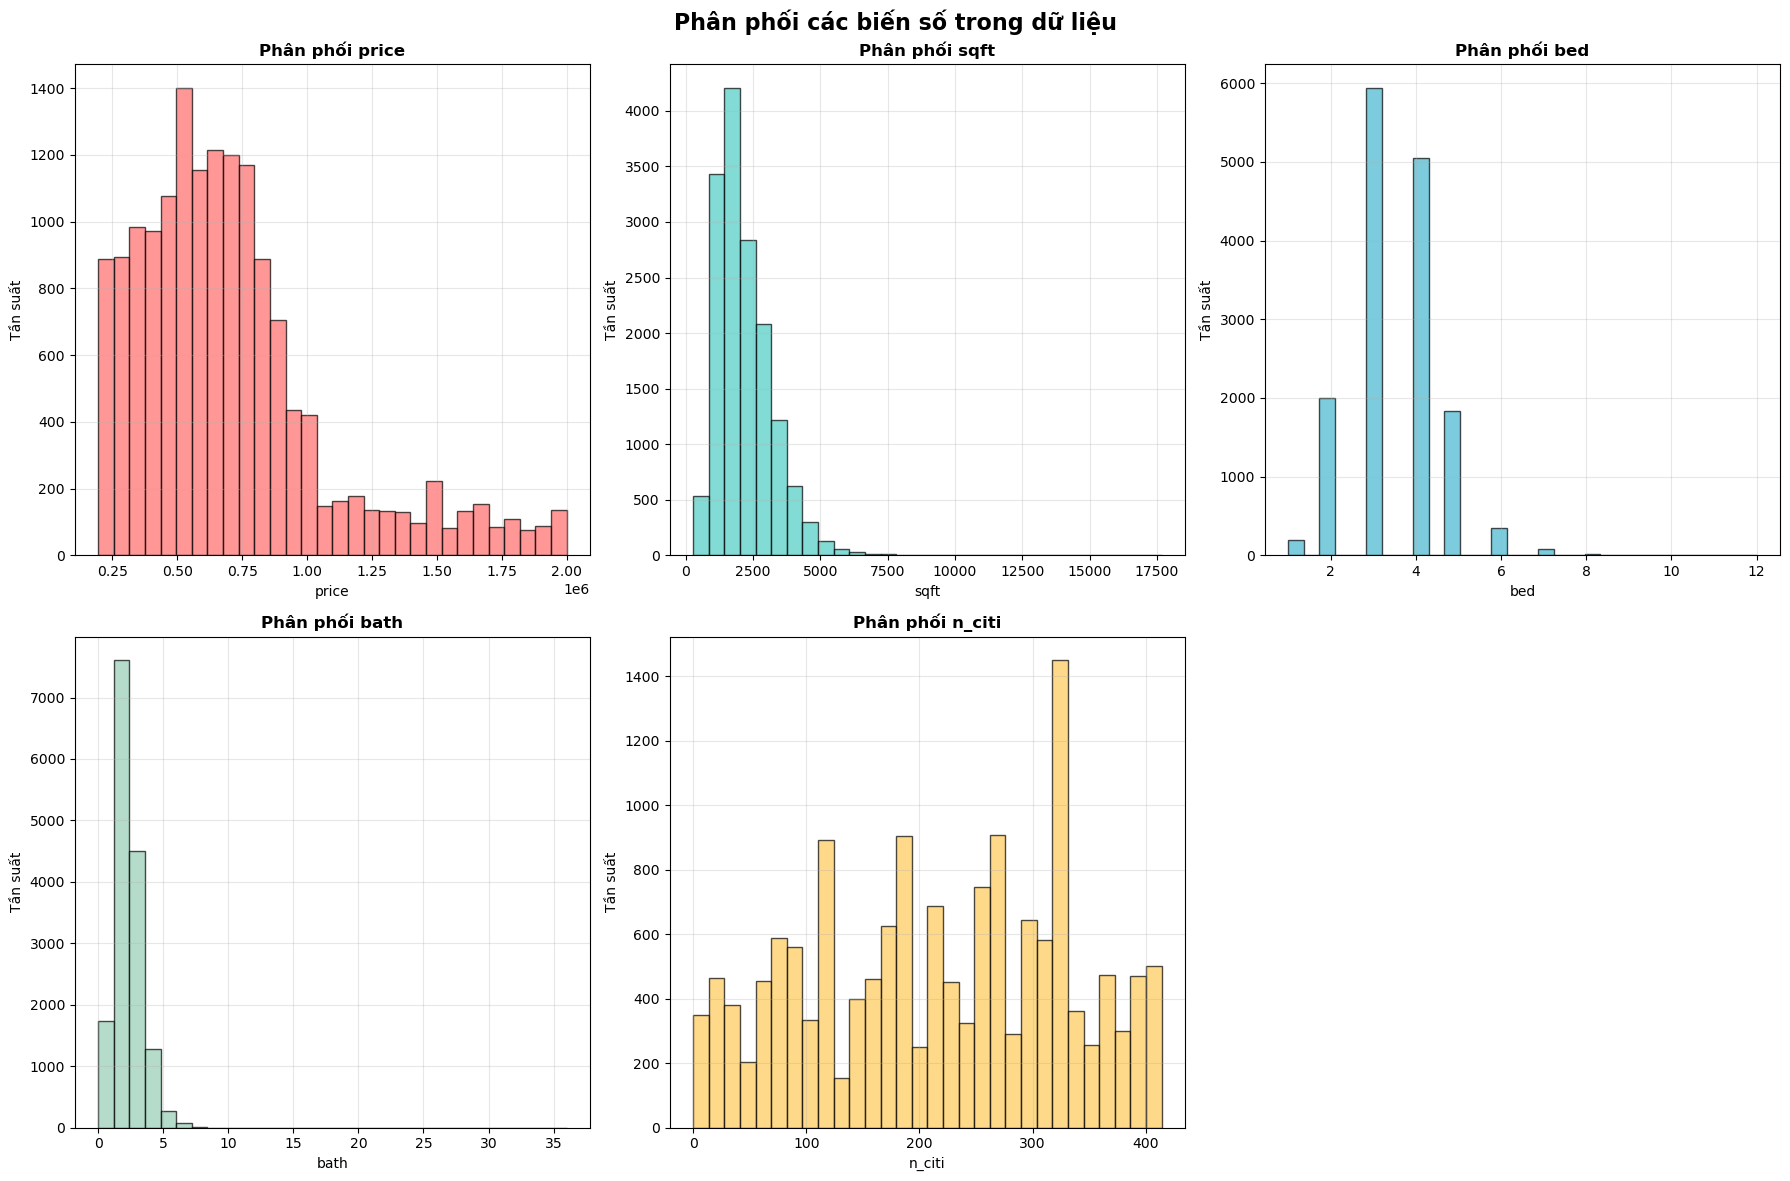

In [12]:

df_pandas = df.toPandas()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Phân phối các biến số trong dữ liệu', fontsize=16, fontweight='bold')

numeric_vars = ['price', 'sqft', 'bed', 'bath', 'n_citi']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

for i, var in enumerate(numeric_vars):
    row = i // 3
    col = i % 3
    
    axes[row, col].hist(df_pandas[var], bins=30, alpha=0.7, color=colors[i], edgecolor='black')
    axes[row, col].set_title(f'Phân phối {var}', fontweight='bold')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Tần suất')
    axes[row, col].grid(True, alpha=0.3)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

Nhận xét:
- Giá (price) có phân phối lệch phải

- Diện tích (sqft) cũng lệch phải, phần lớn nhà có diện tích nhỏ.

- Số phòng ngủ (bed) và phòng tắm (bath) tập trung chủ yếu ở mức 2–4 phòng.

- n_citi phân bố khá đồng đều, không tập trung mạnh ở giá trị nào.

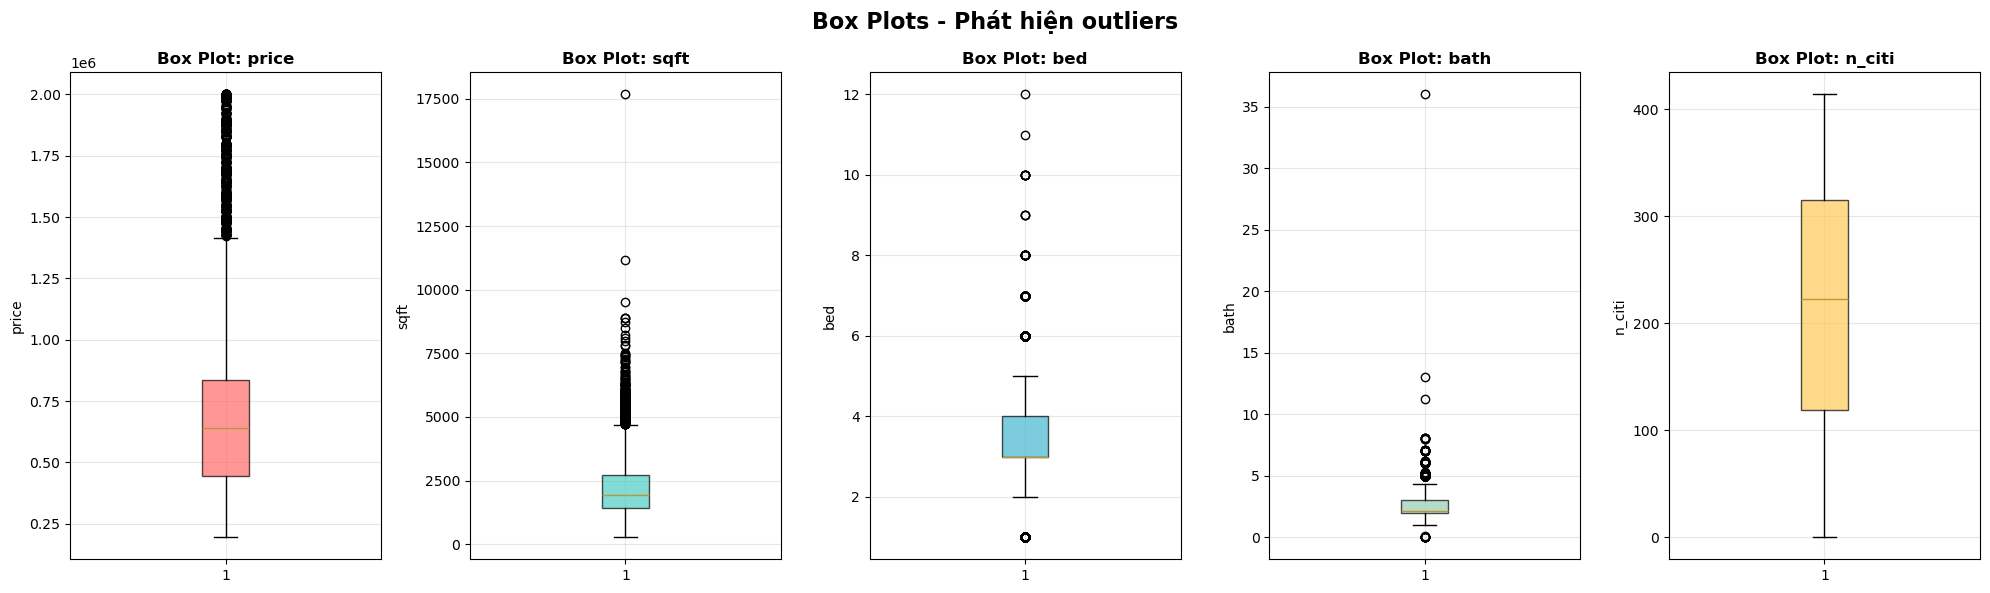

In [13]:

fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Box Plots - Phát hiện outliers', fontsize=16, fontweight='bold')

for i, var in enumerate(numeric_vars):
    box_plot = axes[i].boxplot(df_pandas[var], patch_artist=True)
    axes[i].set_title(f'Box Plot: {var}', fontweight='bold')
    axes[i].set_ylabel(var)
    
    box_plot['boxes'][0].set_facecolor(colors[i])
    box_plot['boxes'][0].set_alpha(0.7)
    
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Nhận xét:
Các biến price, sqft, bed, bath đều có nhiều outlier ở phía trên, đặc biệt là sqft và bath.

Biến n_citi có phân bố khá ổn định, ít giá trị ngoại lệ.
-> Dữ liệu có một số mẫu giá trị cao bất thường cần được xem xét xử lý trước khi phân tích hoặc huấn luyện mô hình.

### 2. Ma trận tương quan và scatter plots

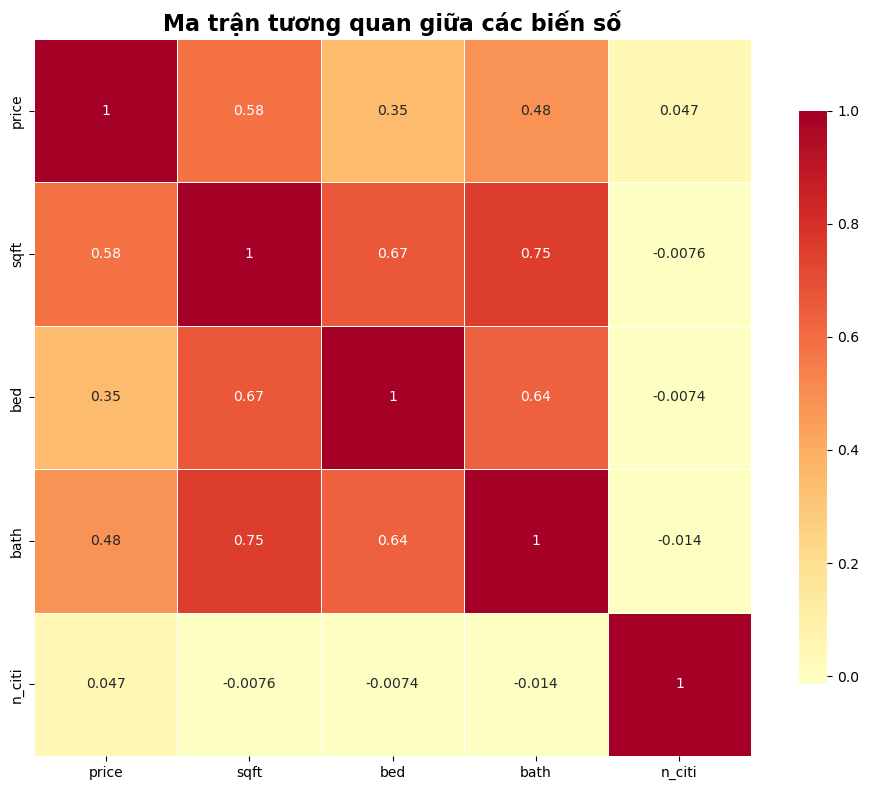

Hệ số tương quan với giá nhà:
sqft      :  0.583
bath      :  0.478
bed       :  0.349
n_citi    :  0.047


In [14]:
# Ma trận tương quan
correlation_matrix = df_pandas[numeric_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Ma trận tương quan giữa các biến số', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Hệ số tương quan với giá nhà:")
print("=" * 40)
price_corr = correlation_matrix['price'].sort_values(ascending=False)
for var, corr in price_corr.items():
    if var != 'price':
        print(f"{var:10s}: {corr:6.3f}")

Nhận xét:
- sqft, bed, bath có ảnh hưởng nhiều đến giá nhà
- citi có ảnh hưởng nhưng không đáng kể

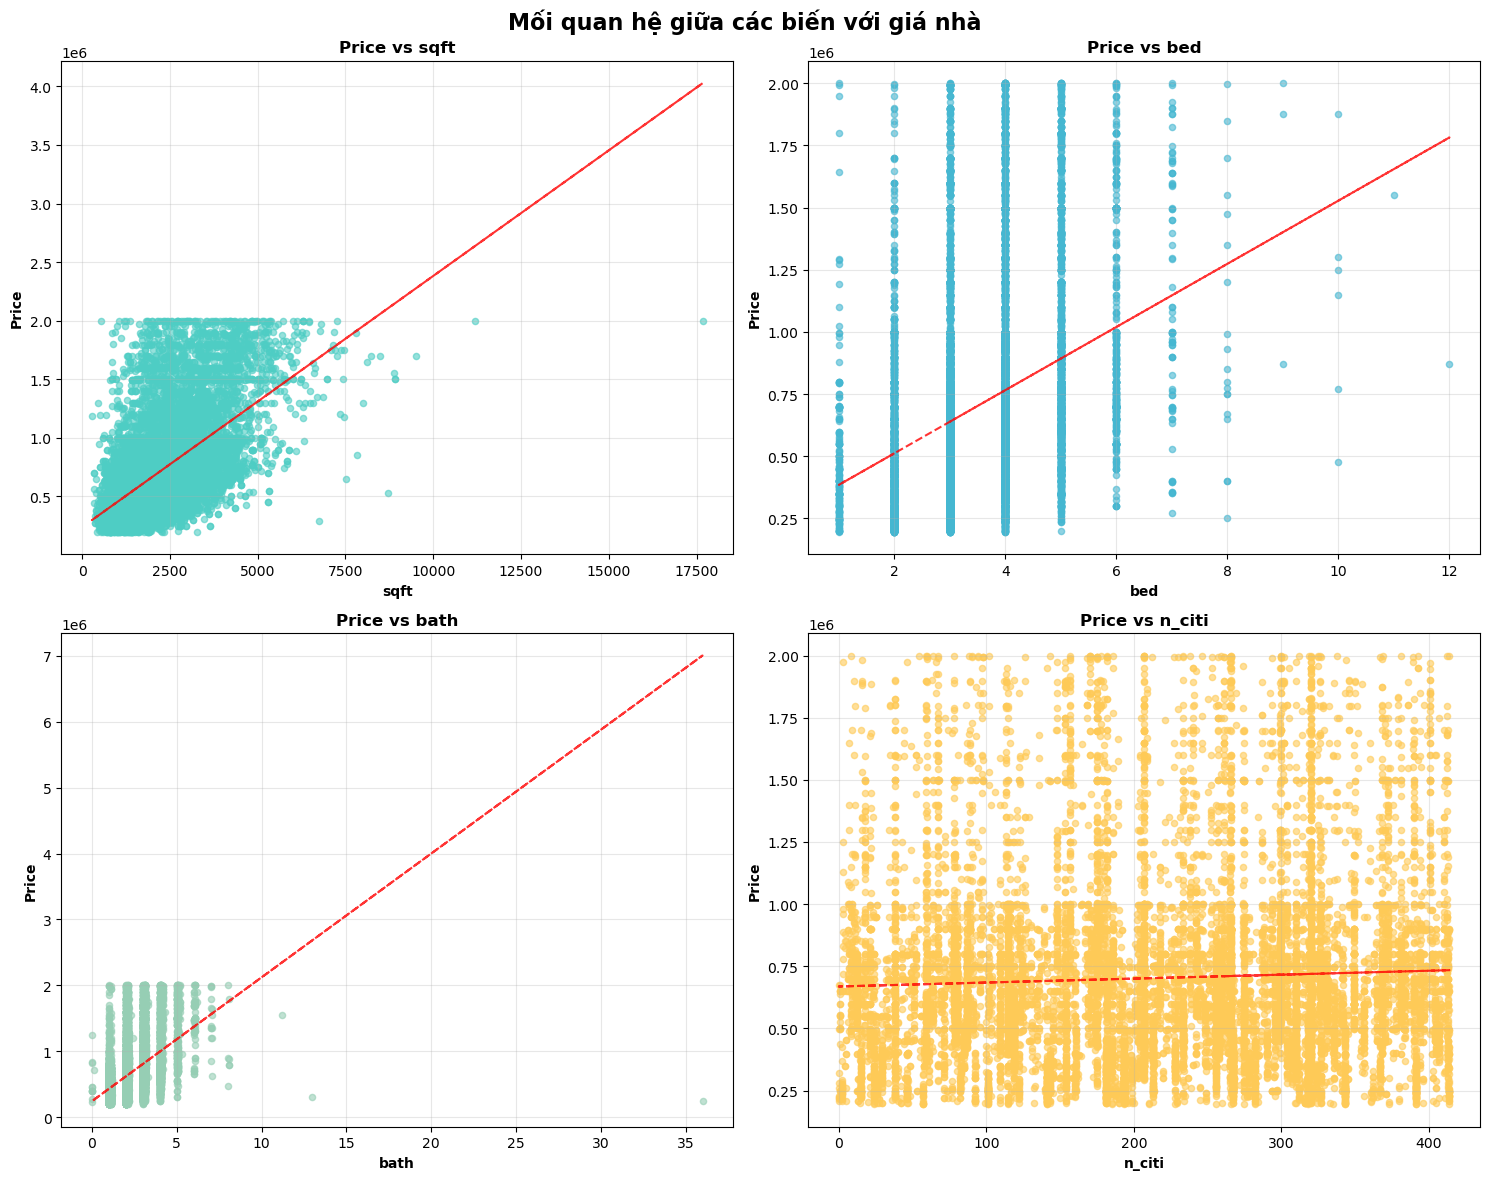

In [15]:
# Scatter plots với price
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Mối quan hệ giữa các biến với giá nhà', fontsize=16, fontweight='bold')

scatter_vars = ['sqft', 'bed', 'bath', 'n_citi']

for i, var in enumerate(scatter_vars):
    row = i // 2
    col = i % 2
    
    axes[row, col].scatter(df_pandas[var], df_pandas['price'], 
                          alpha=0.6, color=colors[i+1], s=20)
    axes[row, col].set_xlabel(var, fontweight='bold')
    axes[row, col].set_ylabel('Price', fontweight='bold')
    axes[row, col].set_title(f'Price vs {var}', fontweight='bold')
    axes[row, col].grid(True, alpha=0.3)
    
    z = np.polyfit(df_pandas[var], df_pandas['price'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(df_pandas[var], p(df_pandas[var]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

Nhận xét:
- Giá nhà (price) có mối tương quan dương rõ rệt với diện tích (sqft) — nhà càng lớn thì giá càng cao.

- Số phòng ngủ (bed) và số phòng tắm (bath) cũng có xu hướng tăng cùng giá, nhưng mối quan hệ yếu hơn.

- n_citi gần như không có tương quan đáng kể với giá nhà.
-> Nhìn chung, diện tích là yếu tố ảnh hưởng mạnh nhất đến giá nhà trong các biến được xét.